In [1]:
import torch
from torch import nn
import math

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib
import torch.optim as optim
from tqdm import tqdm

c:\Users\KandaMaya\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        # convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(4096, 10)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        # flatten for FC
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [3]:
def train(model, trainloader, optimizer, loss_func):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    # For every batch
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(image)
        loss = loss_func(outputs, labels)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()
    
    epoch_loss = train_running_loss / len(trainloader)
    epoch_acc = (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [4]:
def validate(model, testloader, loss_func):
    model.eval()

    class_correct = [0.] * 10
    class_total = [0.] * 10

    valid_running_loss = 0.0
    valid_running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)

            outputs = model(image)
            loss = loss_func(outputs, labels)
            valid_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

    epoch_loss = valid_running_loss / len(testloader)
    epoch_acc = (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [5]:
matplotlib.style.use('ggplot')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
download_data = True
# device = torch.device('cpu')
epochs = 10
batch_size = 32

transform = transforms.Compose(
    [transforms.Resize((32, 32)),
     transforms.ToTensor()])
loss_func = nn.CrossEntropyLoss()
model = VGG11().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)

# training dataset and data loader
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                             download=download_data, 
                                             transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=batch_size,
                                               shuffle=True)
# validation dataset and dataloader
valid_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                           download=download_data, 
                                           transform=transform)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, 
                                             batch_size=batch_size,
                                             shuffle=False)
                                             

In [6]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_dataloader, 
                                              optimizer, loss_func)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_dataloader,  
                                                 loss_func)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print('\n')
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)

[INFO]: Epoch 1 of 10


  0%|          | 0/1875 [00:00<?, ?it/s]c:\Users\KandaMaya\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
100%|██████████| 313/313 [00:01<00:00, 212.95it/s]




Training loss: 1.773, training acc: 0.320
Validation loss: 0.592, validation acc: 0.959
--------------------------------------------------
[INFO]: Epoch 2 of 10


 14%|█▍        | 263/1875 [00:02<00:13, 120.08it/s]


KeyboardInterrupt: 

In [7]:
def test_flip(_model):
    lr_flip_transform = transforms.Compose(
        [transforms.Resize((32, 32)),
        transforms.RandomHorizontalFlip(p=1),
        transforms.ToTensor()])

    td_flip_transform = transforms.Compose(
        [transforms.Resize((32, 32)),
        transforms.RandomVerticalFlip(p=1),
        transforms.ToTensor()])
        
    # validation dataset and dataloader
    lr_flip_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                            download=download_data, 
                                            transform=lr_flip_transform)
    lr_flip_dataloader = torch.utils.data.DataLoader(lr_flip_dataset, 
                                                batch_size=batch_size,
                                                shuffle=False)

    # validation dataset and dataloader
    td_flip_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                            download=download_data, 
                                            transform=td_flip_transform)
    td_flip_dataloader = torch.utils.data.DataLoader(td_flip_dataset, 
                                                batch_size=batch_size,
                                                shuffle=False)

    lr_flip_loss, lr_flip_acc = validate(_model, lr_flip_dataloader, loss_func)
    td_flip_loss, td_flip_acc = validate(_model, td_flip_dataloader, loss_func)
    print(f"Horizontal flip loss: {lr_flip_loss}, Accuracy: {100. * lr_flip_acc}%")
    print(f"Vertical flip loss: {td_flip_loss}, Accuracy: {100. * td_flip_acc}%")

In [8]:
def test_noise(_model):
    for variance in [0.01, 0.1, 1]:
        stddev = math.sqrt(variance)
        gaussian_noise_transform = transforms.Compose(
            [transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Lambda(lambda x : x + stddev*torch.randn_like(x))
            ])
            
        # validation dataset and dataloader
        gaussian_noise_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                                download=download_data, 
                                                transform=gaussian_noise_transform)
        gaussian_noise_dataloader = torch.utils.data.DataLoader(gaussian_noise_dataset, 
                                                    batch_size=batch_size,
                                                    shuffle=False)
        gaussian_noise_loss, gaussian_noise_acc = validate(_model, gaussian_noise_dataloader, loss_func)
        print(f"Gaussian noise with variance {variance} loss: {gaussian_noise_loss}, Accuracy: {100. * gaussian_noise_acc}%")

In [9]:
test_flip(model)
test_noise(model)

100%|██████████| 313/313 [00:01<00:00, 157.73it/s]


Horizontal flip loss: 1.928394480635183, Accuracy: 38.43%
Vertical flip loss: 1.9220517032062665, Accuracy: 43.309999999999995%


100%|██████████| 313/313 [00:01<00:00, 171.00it/s]


Gaussian noise with variance 0.01 loss: 0.5477761311081651, Accuracy: 97.39%


100%|██████████| 313/313 [00:01<00:00, 177.90it/s]


Gaussian noise with variance 0.1 loss: 2.3260483970276464, Accuracy: 10.780000000000001%


100%|██████████| 313/313 [00:01<00:00, 163.58it/s]

Gaussian noise with variance 1 loss: 5.4684271934314275, Accuracy: 9.74%


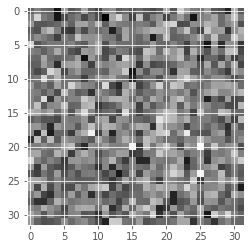

In [10]:

gaussian_noise_transform = transforms.Compose(
        [transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x : x + 1*torch.randn_like(x))
        ])
        
# validation dataset and dataloader
gaussian_noise_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=download_data, 
                                        transform=gaussian_noise_transform)
gaussian_noise_dataloader = torch.utils.data.DataLoader(gaussian_noise_dataset, 
                                            batch_size=batch_size,
                                            shuffle=False)
images, labels = next(iter(gaussian_noise_dataloader))
plt.imshow(images[4].reshape(32,32), cmap="gray")

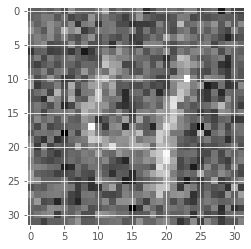

In [11]:
gaussian_noise_transform = transforms.Compose(
        [transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x : x + math.sqrt(0.1)*torch.randn_like(x))
        ])
        
# validation dataset and dataloader
gaussian_noise_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=download_data, 
                                        transform=gaussian_noise_transform)
gaussian_noise_dataloader = torch.utils.data.DataLoader(gaussian_noise_dataset, 
                                            batch_size=batch_size,
                                            shuffle=False)
images, labels = next(iter(gaussian_noise_dataloader))
plt.imshow(images[4].reshape(32,32), cmap="gray")

In [12]:
gaussian_min_noise_transform = transforms.Compose(
        [transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x : x + math.sqrt(0.01)*torch.randn_like(x))
        ])
        
# validation dataset and dataloader
gaussian_min_noise_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=download_data, 
                                        transform=gaussian_min_noise_transform)
gaussian_min_noise_dataloader = torch.utils.data.DataLoader(gaussian_min_noise_dataset, 
                                            batch_size=batch_size,
                                            shuffle=False)
images, labels = next(iter(gaussian_min_noise_dataloader))
plt.imshow(images[4].reshape(32,32), cmap="gray")\

SyntaxError: incomplete input (1995818979.py, line 15)

In [ ]:
aug_lr_transform = transforms.Compose(
    [transforms.Resize((32, 32)),
     transforms.RandomHorizontalFlip(p=1),
     transforms.ToTensor(),
     transforms.Lambda(lambda x : x + math.sqrt(0.01)*torch.randn_like(x)),
     ])

aug_td_transform = transforms.Compose(
    [transforms.Resize((32, 32)),
     transforms.RandomVerticalFlip(p=1),
     transforms.ToTensor(),
     transforms.Lambda(lambda x : x + math.sqrt(0.01)*torch.randn_like(x)),
     ])

# training dataset and data loader
aug_lr_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                             download=download_data, 
                                             transform=aug_lr_transform)

# training dataset and data loader
aug_td_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                             download=download_data, 
                                             transform=aug_td_transform)


aug_loader_cat = torch.utils.data.ConcatDataset([aug_lr_dataset, aug_td_dataset])
aug_loader = torch.utils.data.DataLoader(aug_loader_cat, batch_size=batch_size, shuffle=True)

In [ ]:
aug_loss_func = nn.CrossEntropyLoss()
aug_model = VGG11().to(device)
aug_optimizer = optim.SGD(aug_model.parameters(), lr=0.01)

aug_train_loss, aug_valid_loss = [], []
aug_train_acc, aug_valid_acc = [], []
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    aug_train_epoch_loss, aug_train_epoch_acc = train(aug_model, aug_loader, 
                                              aug_optimizer, aug_loss_func)
    aug_valid_epoch_loss, aug_valid_epoch_acc = validate(aug_model, valid_dataloader,  
                                                 aug_loss_func)
    aug_train_loss.append(aug_train_epoch_loss)
    aug_valid_loss.append(aug_valid_epoch_loss)
    aug_train_acc.append(aug_train_epoch_acc)
    aug_valid_acc.append(aug_valid_epoch_acc)
    print('\n')
    print(f"aug_training loss: {aug_train_epoch_loss:.3f}, aug_training acc: {aug_train_epoch_acc:.3f}")
    print(f"aug_validation loss: {aug_valid_epoch_loss:.3f}, aug_validation acc: {aug_valid_epoch_acc:.3f}")
    print('-'*50)

[INFO]: Epoch 1 of 10


100%|██████████| 313/313 [00:01<00:00, 216.26it/s]




aug_training loss: 2.026, aug_training acc: 0.313
aug_validation loss: 1.758, aug_validation acc: 0.491
--------------------------------------------------
[INFO]: Epoch 2 of 10


100%|██████████| 313/313 [00:01<00:00, 214.04it/s]




aug_training loss: 1.833, aug_training acc: 0.327
aug_validation loss: 1.748, aug_validation acc: 0.512
--------------------------------------------------
[INFO]: Epoch 3 of 10


100%|██████████| 313/313 [00:01<00:00, 215.94it/s]




aug_training loss: 1.793, aug_training acc: 0.331
aug_validation loss: 1.743, aug_validation acc: 0.510
--------------------------------------------------
[INFO]: Epoch 4 of 10


100%|██████████| 313/313 [00:01<00:00, 223.36it/s]




aug_training loss: 1.783, aug_training acc: 0.328
aug_validation loss: 1.795, aug_validation acc: 0.460
--------------------------------------------------
[INFO]: Epoch 5 of 10


100%|██████████| 313/313 [00:01<00:00, 221.62it/s]




aug_training loss: 1.768, aug_training acc: 0.331
aug_validation loss: 1.762, aug_validation acc: 0.487
--------------------------------------------------
[INFO]: Epoch 6 of 10


100%|██████████| 313/313 [00:01<00:00, 224.48it/s]




aug_training loss: 1.759, aug_training acc: 0.331
aug_validation loss: 1.749, aug_validation acc: 0.503
--------------------------------------------------
[INFO]: Epoch 7 of 10


100%|██████████| 313/313 [00:01<00:00, 222.25it/s]




aug_training loss: 1.761, aug_training acc: 0.329
aug_validation loss: 1.891, aug_validation acc: 0.457
--------------------------------------------------
[INFO]: Epoch 8 of 10


100%|██████████| 313/313 [00:01<00:00, 217.01it/s]




aug_training loss: 1.752, aug_training acc: 0.332
aug_validation loss: 1.766, aug_validation acc: 0.469
--------------------------------------------------
[INFO]: Epoch 9 of 10


100%|██████████| 313/313 [00:01<00:00, 214.04it/s]




aug_training loss: 1.750, aug_training acc: 0.331
aug_validation loss: 1.694, aug_validation acc: 0.483
--------------------------------------------------
[INFO]: Epoch 10 of 10


100%|██████████| 313/313 [00:01<00:00, 213.75it/s]



aug_training loss: 1.745, aug_training acc: 0.333
aug_validation loss: 1.692, aug_validation acc: 0.485
--------------------------------------------------


In [ ]:
aug_lr_transform = transforms.Compose(
    [transforms.Resize((32, 32)),
     transforms.RandomHorizontalFlip(p=1),
     transforms.ToTensor(),
     transforms.Lambda(lambda x : x + math.sqrt(0.01)*torch.randn_like(x)),
     ])

aug_td_transform = transforms.Compose(
    [transforms.Resize((32, 32)),
     transforms.RandomVerticalFlip(p=1),
     transforms.ToTensor(),
     transforms.Lambda(lambda x : x + math.sqrt(0.01)*torch.randn_like(x)),
     ])

# training dataset and data loader
aug_lr_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                             download=download_data, 
                                             transform=aug_lr_transform)

# training dataset and data loader
aug_td_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                             download=download_data, 
                                             transform=aug_td_transform)


aug_loader_cat = torch.utils.data.ConcatDataset([aug_lr_dataset, aug_td_dataset])
aug_loader = torch.utils.data.DataLoader(aug_loader_cat, batch_size=batch_size, shuffle=True)

In [ ]:
test_flip(aug_model)
test_noise(aug_model)

100%|██████████| 313/313 [00:02<00:00, 144.14it/s]


Horizontal flip loss: 0.3185465452008354, Accuracy: 98.75%
Vertical flip loss: 0.33421257652413733, Accuracy: 98.71%


100%|██████████| 313/313 [00:01<00:00, 159.58it/s]


Gaussian noise with variance 0.01 loss: 1.7181770721563516, Accuracy: 48.0%


100%|██████████| 313/313 [00:01<00:00, 183.86it/s]


Gaussian noise with variance 0.1 loss: 1.89471795726508, Accuracy: 44.269999999999996%


100%|██████████| 313/313 [00:01<00:00, 168.42it/s]

Gaussian noise with variance 1 loss: 2.490477479684848, Accuracy: 14.7%
